In [1]:
import xmlrpc.client
import numpy as np
import pandas as pd
from skimage.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('../../data/ST001237_AN002055.csv')

In [3]:
df.drop(['Sample ID', 'Trial', 'raw file name', 'OS_Censor (1 means the time is a censoring time and 0 means a failure time in OS)'], axis=1, inplace=True)

Data cleaning and preprocessing

In [19]:

# rename columns to be more readable
df.rename(columns={'Time point': 'time_point',
                   'OS (Overall Survival, months)': 'os_time',
                   'Prior antiangiogenic regimens (≥2)': 'prior_antiangiogenic_regimens',
                   'Derived_Age_at_Consent': 'Age'
                   },
          inplace=True)

# Time point in days instead of weeks and baseline as 0 d
df['time_point'] = df['time_point'].apply(lambda x: 0 if x == 'baseline' else int(str(x).replace('week ', '')) * 7)
df['CRF_MSKCC_Risk_Group'] = df['CRF_MSKCC_Risk_Group'].apply(
    lambda x: 0 if x == 'POOR' else 1 if x == 'INTERMEDIATE' else 2)
df['Sex'] = df['Sex'].apply(lambda x: 0 if x == 'F' else 1)
df['Treatment'] = df['Treatment'].apply(lambda x: 0 if x == 'NIVOLUMAB' else 1)
df['Region'] = df['Region'].apply(lambda x: df['Region'].unique().tolist().index(x))
df['Race'] = df['Race'].apply(lambda x: 0 if x == 'WHITE' else 1)
df['prior_antiangiogenic_regimens'] = df['prior_antiangiogenic_regimens'].apply(lambda x: 0 if x == 'False' else int(x))
df['os_time'] = df['os_time'].astype(int)

df.describe()

,time_point,CRF_MSKCC_Risk_Group,Treatment,prior_antiangiogenic_regimens,os_time,Region,Age,Sex,Race,Kynurenine_μM,...,C36:2 PS plasmalogen,C16:0 ceramide (d18:1),C24:1 ceramide (d18:1),C14:0 SM,C16:1 SM,C16:0 SM,C18:1 SM,C18:2 SM,C18:0 SM,C20:0 SM
count,1221.000000,1221.0,1221.0,1221.000000,1221.000000,1221.000000,1221.000000,1221.0,1221.0,1221.000000,...,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000,1221.000000
mean,129.061425,2.0,1.0,0.226044,25.097461,1.203112,61.226044,1.0,1.0,6.582139,...,5.791247,5.734799,6.380391,6.449352,6.616477,7.470586,6.444245,4.787712,6.788397,6.751793
std,170.443049,0.0,0.0,0.418440,15.295274,0.814635,10.469378,0.0,0.0,1.499580,...,0.249380,0.173388,0.162301,0.162414,0.128217,0.104635,0.156408,0.310861,0.134258,0.122432
min,0.000000,2.0,1.0,0.000000,0.000000,0.000000,23.000000,1.0,1.0,3.373000,...,5.272000,5.139000,5.853000,5.943000,6.180000,7.113000,5.915000,2.684000,6.310000,6.263000
25%,0.000000,2.0,1.0,0.000000,12.000000,0.000000,55.000000,1.0,1.0,5.581000,...,5.650000,5.618000,6.269000,6.344000,6.538000,7.403000,6.344000,4.627000,6.702000,6.678000
50%,0.000000,2.0,1.0,0.000000,23.000000,1.000000,62.000000,1.0,1.0,6.337000,...,5.755000,5.731000,6.379000,6.451000,6.614000,7.473000,6.447000,4.811000,6.792000,6.754000
75%,392.000000,2.0,1.0,0.000000,40.000000,2.000000,69.000000,1.0,1.0,7.257000,...,5.869000,5.854000,6.493000,6.558000,6.696000,7.539000,6.545000,4.990000,6.880000,6.832000
max,392.000000,2.0,1.0,1.000000,53.000000,2.000000,88.000000,1.0,1.0,15.001000,...,7.061000,6.439000,7.088000,6.989000,7.047000,7.818000,6.976000,5.861000,7.244000,7.255000


array([[<Axes: title={'center': 'time_point'}>,
        <Axes: title={'center': 'CRF_MSKCC_Risk_Group'}>,
        <Axes: title={'center': 'Treatment'}>,
        <Axes: title={'center': 'prior_antiangiogenic_regimens'}>,
        <Axes: title={'center': 'os_time'}>,
        <Axes: title={'center': 'Region'}>,
        <Axes: title={'center': 'Age'}>, <Axes: title={'center': 'Sex'}>,
        <Axes: title={'center': 'Race'}>,
        <Axes: title={'center': 'Kynurenine_μM'}>,
        <Axes: title={'center': 'Tryptophan_μM'}>,
        <Axes: title={'center': 'Kyn/Trp'}>,
        <Axes: title={'center': 'adenosine'}>,
        <Axes: title={'center': 'inosine'}>,
        <Axes: title={'center': 'kynurenine'}>],
       [<Axes: title={'center': 'tryptophan'}>,
        <Axes: title={'center': '1,7-dimethyluric acid'}>,
        <Axes: title={'center': '1-methyladenosine'}>,
        <Axes: title={'center': '1-methylguanosine'}>,
        <Axes: title={'center': '1-methylnicotinamide'}>,
        <Axe

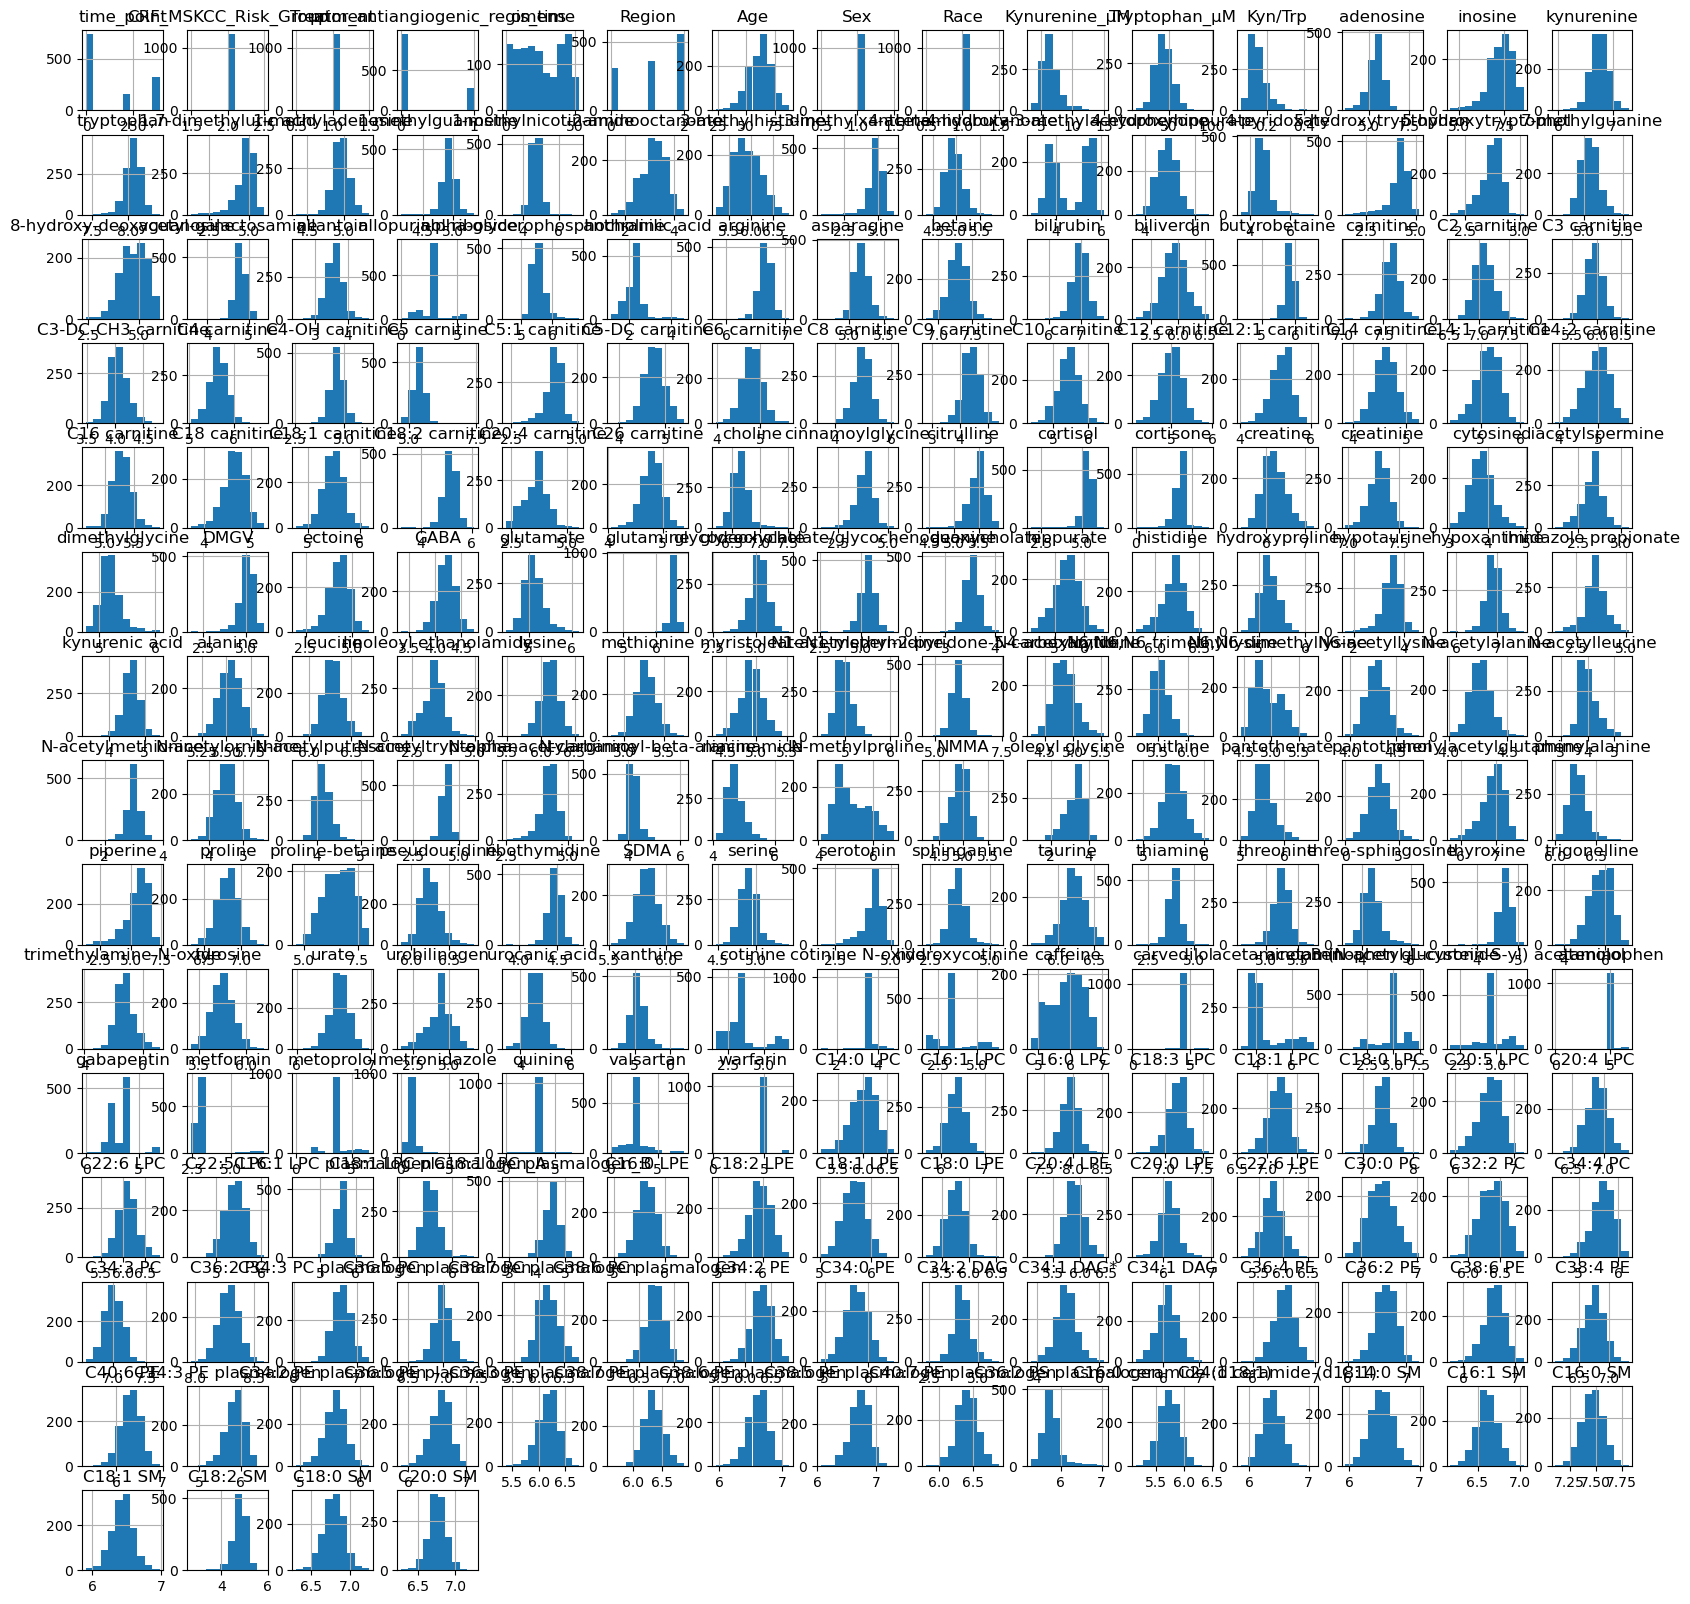

In [20]:
#replace metabolites na values with mean
df.fillna(df.mean(), inplace=True)
df.hist(figsize=(20, 20))

<Figure size 2000x2000 with 0 Axes>

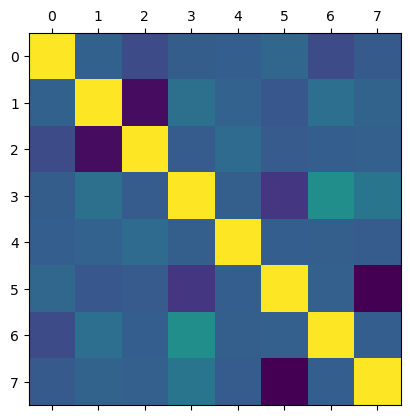

In [18]:

# showing a plot of the correlation matrix
vars = df[['Age', 'Race', 'Region', 'os_time', 'prior_antiangiogenic_regimens', 'Treatment', 'CRF_MSKCC_Risk_Group', 'time_point']]
corr = vars.corr()
plt.figure(figsize=(20, 20))
plt.matshow(corr)

Addestra un modello PLS

In [6]:
X = df.drop(['os_time'], axis=1)
y = df['os_time'].values.reshape(-1, 1)


In [7]:
# Suddividi i dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Crea un modello PLS con un numero di componenti specificato
num_componenti = 2
modello_pls = PLSRegression(n_components=num_componenti)

# Addestra il modello PLS
modello_pls.fit(X_train, y_train)

# Effettua previsioni sul set di test
previsioni = modello_pls.predict(X_test)

# Calcola l'errore quadratico medio (MSE)
mse = mean_squared_error(y_test, previsioni)
print(f"Errore quadratico medio: {mse}")


Errore quadratico medio: 181.05817740094014
